In [1]:
import joblib
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# -------------------------------
# Data Preparation Pipeline (Fixed)
# -------------------------------
# Load raw data
df = pd.read_csv("app_data.csv")

# -------------------------------
# Step 1: Separate Target Column Early
# -------------------------------
# Extract target column and remove it from features
y = df['AppendicitisComplications']
df = df.drop('AppendicitisComplications', axis=1)

# -------------------------------
# Step 2: Preprocess Features Only
# -------------------------------
# Handle missing values for features
numerical_cols = ['Age', 'BMI', 'Height', 'Weight', 'AlvaradoScore',
                 'PediatricAppendicitisScore', 'AppendixDiameter', 'BodyTemp',
                 'WBCCount', 'NeutrophilPerc', 'CRPEntry']
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# -------------------------------
# Step 3: Encode Features (Excluding Target)
# -------------------------------
# Binary encoding for features
binary_mappings = {
    'Sex': {'male': 1, 'female': 0},
    'MigratoryPain': {'yes': 1, 'no': 0},
    # ... (keep other binary mappings)
}

for col, mapping in binary_mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping).fillna(0).astype(int)

# Ordinal encoding for features
ordinal_cols = {
    'KetonesInUrine': {'no': 0, '+': 1, '++': 2, '+++': 3, 'Unknown': 0},
    # ... (keep other ordinal mappings)
}

for col, mapping in ordinal_cols.items():
    if col in df.columns:
        df[col] = df[col].map(mapping).fillna(0).astype(int)

# Convert remaining categoricals to one-hot
df = pd.get_dummies(df, drop_first=True)

# -------------------------------
# Step 4: Reattach Target Column
# -------------------------------
# Convert target to binary and merge back
y = y.map({'yes': 1, 'no': 0})
df['AppendicitisComplications'] = y  # Reattach target

# -------------------------------
# Step 5: Final Validation
# -------------------------------
# Check target exists
if 'AppendicitisComplications' not in df.columns:
    raise KeyError("Target column is missing after preprocessing.")

# Check data types
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print("Non-numeric columns remaining:", non_numeric)
else:
    print("All columns are numeric.")

# Standardize features (excluding target)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Save cleaned data
df.to_csv("fixed_processed_data.csv", index=False)

Non-numeric columns remaining: ['AppendixOnSono_no', 'AppendixOnSono_yes', 'LowerAbdominalPainRight_no', 'LowerAbdominalPainRight_yes', 'ReboundTenderness_no', 'ReboundTenderness_yes', 'CoughingPain_no', 'CoughingPain_yes', 'PsoasSign_negative', 'PsoasSign_positive', 'Nausea_yes', 'AppetiteLoss_no', 'AppetiteLoss_yes', 'ErythrocytesInUrine_++', 'ErythrocytesInUrine_+++', 'ErythrocytesInUrine_Unknown', 'ErythrocytesInUrine_no', 'WBCInUrine_++', 'WBCInUrine_+++', 'WBCInUrine_Unknown', 'WBCInUrine_no', 'Dysuria_no', 'Dysuria_yes', 'Stool_diarrhea', 'Stool_normal', 'Stool_obstipation', 'Peritonitis_local', 'Peritonitis_no', 'FreeFluids_no', 'FreeFluids_yes', 'AppendixWallLayers_aufgehoben', 'AppendixWallLayers_intakt', 'Kokarde_no', 'Kokarde_yes', 'TissuePerfusion_hyperperfused', 'TissuePerfusion_hypoperfused', 'TissuePerfusion_unremarkable', 'SurroundingTissueReaction_no', 'SurroundingTissueReaction_yes', 'PathLymphNodes_no', 'PathLymphNodes_yes', 'MesentricLymphadenitis_no', 'MesentricLy

c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e


=== Training Random Forest ===

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94        76
           1       0.50      0.40      0.44        10

    accuracy                           0.88        86
   macro avg       0.71      0.67      0.69        86
weighted avg       0.87      0.88      0.88        86


=== Training XGBoost ===

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        76
           1       0.50      0.50      0.50        10

    accuracy                           0.88        86
   macro avg       0.72      0.72      0.72        86
weighted avg       0.88      0.88      0.88        86


=== Training Gradient Boosting ===

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93        76
           1       0.45      0.50      0.48        10

    ac

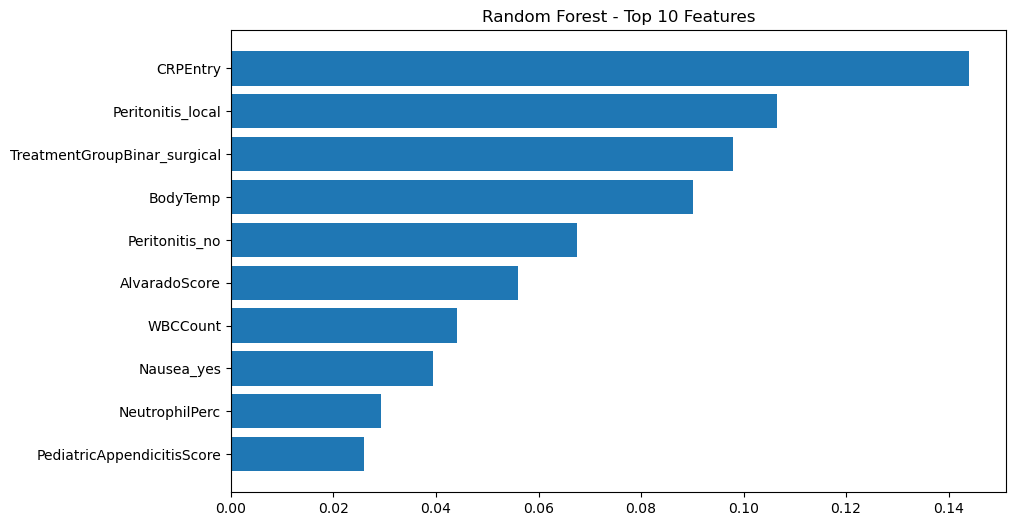

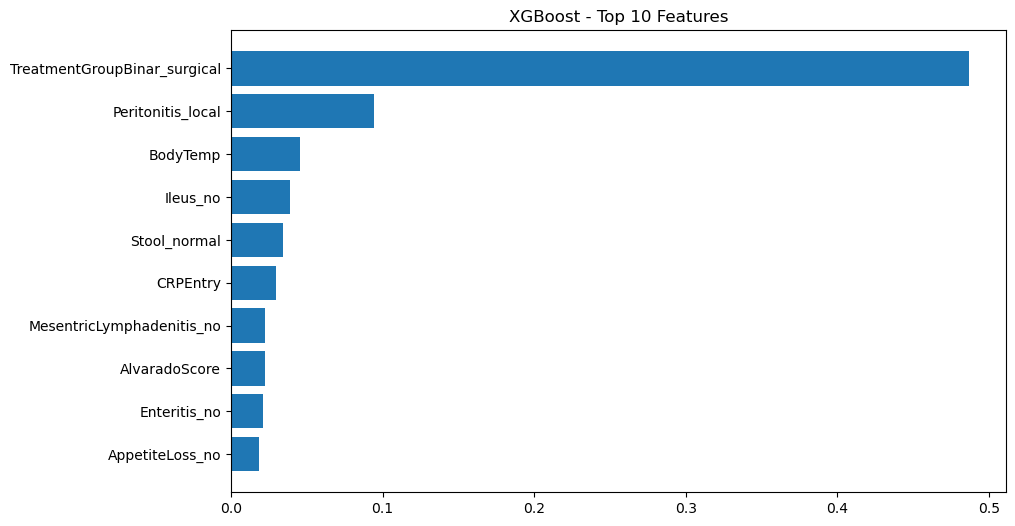

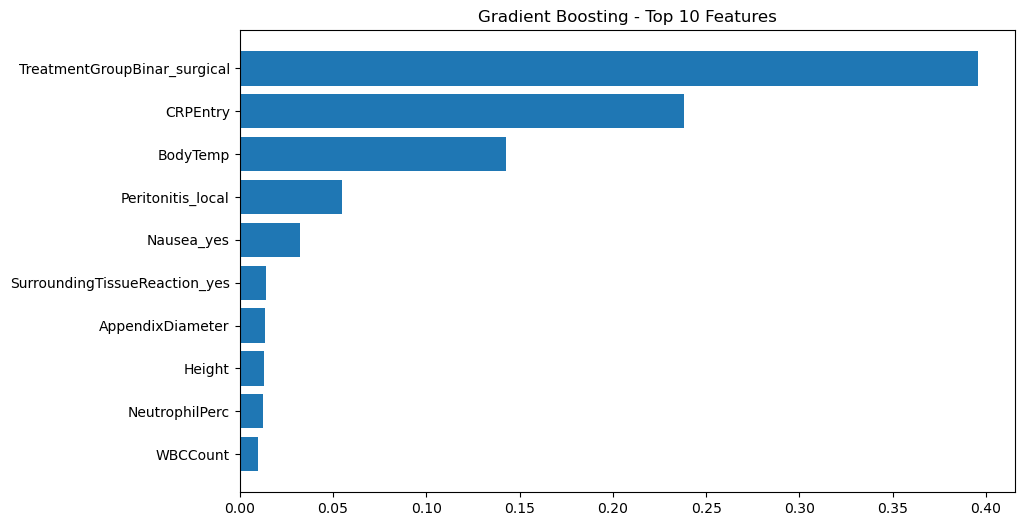

In [4]:

# -------------------------------
# Model Training Pipeline
# -------------------------------


# Load processed data
df = pd.read_csv("fixed_processed_data.csv")

# Ensure target column exists
if 'AppendicitisComplications' not in df.columns:
    raise KeyError("Target column 'AppendicitisComplications' is missing in the processed data.")

# Split features and target
X = df.drop('AppendicitisComplications', axis=1)
y = df['AppendicitisComplications']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    results[name] = {
        'ROC AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        'Classification Report': classification_report(y_test, y_pred)
    }
    print(f"\n{name} Performance:")
    print(results[name]['Classification Report'])

# Print final comparison
print("\n=== Final Model Comparison ===")
for name, metrics in results.items():
    print(f"\n{name}: ROC AUC = {metrics['ROC AUC']:.4f}")

# Feature Importance Visualization
os.makedirs("saved_models", exist_ok=True)

# Save each trained model
for name, model in models.items():
    joblib.dump(model, f"saved_models/{name.replace(' ', '_')}.joblib")
    print(f"Model {name} saved successfully")

for name in models:
    if hasattr(models[name], 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        importances = models[name].feature_importances_
        indices = np.argsort(importances)[-10:]
        plt.title(f'{name} - Top 10 Features')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
        plt.show()